# [Training models on atlas-scale single-cell datasets] – [scverse Conference 2024]

[Training models on atlas-scale single-cell datasets]: https://cfp.scverse.org/2024/talk/GQHNYE/
[scverse Conference 2024]: https://scverse.org/conference2024

### TileDB-SOMA / Census Hello World

Load the necessary libraries (sample requirements file [here][requirements-nb.txt]):

[requirements-nb.txt]: https://github.com/TileDB-Inc/scverse-ml-workshop-2024/blob/main/requirements-nb.txt

In [1]:
import cellxgene_census
import tiledbsoma
import scipy
import numpy
import scanpy as sc
import pandas

#### Finding Census versions available

Let's first take a look at the data releases available in S3. There are two types of releases:
- **Long-term supported (LTS) data releases** published every six months to be avalialbe for up to 5 years.
- **Weekly releases** to be available for up to 6 weeks.

To see a list of all available releases and their version aliases, we can do the following

In [2]:
cellxgene_census.get_census_version_directory()

OrderedDict([('stable',
              {'release_date': None,
               'release_build': '2024-07-01',
               'soma': {'uri': 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/soma/',
                'relative_uri': '/cell-census/2024-07-01/soma/',
                's3_region': 'us-west-2'},
               'h5ads': {'uri': 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/h5ads/',
                'relative_uri': '/cell-census/2024-07-01/h5ads/',
                's3_region': 'us-west-2'},
               'flags': {'lts': True}}),
             ('latest',
              {'release_date': None,
               'release_build': '2024-09-02',
               'soma': {'uri': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/',
                'relative_uri': '/cell-census/2024-09-02/soma/',
                's3_region': 'us-west-2'},
               'h5ads': {'uri': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/h5ads/',
        

In [3]:
cellxgene_census.get_census_version_directory(lts=True)

OrderedDict([('stable',
              {'release_date': None,
               'release_build': '2024-07-01',
               'soma': {'uri': 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/soma/',
                'relative_uri': '/cell-census/2024-07-01/soma/',
                's3_region': 'us-west-2'},
               'h5ads': {'uri': 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/h5ads/',
                'relative_uri': '/cell-census/2024-07-01/h5ads/',
                's3_region': 'us-west-2'},
               'flags': {'lts': True}}),
             ('2024-07-01',
              {'release_date': None,
               'release_build': '2024-07-01',
               'soma': {'uri': 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/soma/',
                'relative_uri': '/cell-census/2024-07-01/soma/',
                's3_region': 'us-west-2'},
               'h5ads': {'uri': 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/h5ads/',
    

#### Opening a Census version

Now we can get a handle to the Census object hosted in S3. Remember that we can specify the data release to use.

In [24]:
# Default: 1GB
# Google colab runs well with 1MB
# TileDB-Cloud can run default, but recommended for workshop is 10MB
config = {
    "vfs.s3.region": "us-west-2",
    "vfs.s3.no_sign_request": "true",
    "py.init_buffer_bytes": 0.001 * 1024**3, #1MB
    "soma.init_buffer_bytes": 0.001 * 1024**3, #1MB
}

ctx = tiledbsoma.options.SOMATileDBContext(tiledb_config=config)
ctx = ctx.replace(tiledb_config=config)

In [25]:
# For the latest LTS use "stable", other options are "latest" for the latest
# weekly, or specific version

version = "latest"

# equivalent
# version = "2024-09-02"

census = cellxgene_census.open_soma(census_version=version, context=ctx)

#### Inspecting the Census object

These are the types of SOMA objects used by Census:

- `SparseNDArray` is the same as DenseNDArray but sparse, and supports point indexing (disjoint index access).
- `DataFrame` is a multi-column table with user-defined columns names and value types, with support for point indexing.
- `Collection` is a persistent container of named SOMA objects, similar to a dictionary.
- `Experiment` is a class that represents a single-cell experiment. It always contains two objects:
   - `obs`: a `DataFrame` with primary annotations on the observation axis.
   - `ms`: a `Collection` of measurements, each composed of `X` matrices and axis annotation matrices or data frames (e.g. `var`, `varm`, `obsm`, etc).

<img src="soma-data-model.png" style="width: 70%; position: relative; left: 10%" />

The parent Census object is a SOMA `Collection`:

In [6]:
census

<Collection 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/' (open for 'r') (2 items)
    'census_info': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info' (unopened)
    'census_data': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data' (unopened)>

You can access items of a collection with square brackets.

- `"census_data"` has the Census single-cell data, will explore it in a momemnt.
- `"census_info"` has high-level summary information about Census

Inspecting `"census_info"`:

In [18]:
census["census_info"]

<Collection 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info' (open for 'r') (4 items)
    'datasets': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/datasets' (unopened)
    'summary_cell_counts': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/summary_cell_counts' (unopened)
    'summary': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/summary' (unopened)
    'organisms': DataFrame 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/organisms' (open for 'r')>

There are four items in this collection:

- `"summary"`: A data frame with high-level information of this Census, e.g. build date, total cell count, etc.
- `"summary_cell_counts"`: A data frame with cell counts stratified by relevant cell metadata
- `"datasets"`: A data frame with all datasets from CELLxGENE Discover used to create the Census.
- `"organisms"`: A data frame documenting the species represented in the Census (human and mouse)

Peeking at `"census_data"`:

In [9]:
census["census_data"]

<Collection 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data' (open for 'r') (2 items)
    'homo_sapiens': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data/homo_sapiens' (unopened)
    'mus_musculus': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data/mus_musculus' (unopened)>

These two are SOMA `Experiment` objects which are a specialized form of a `Collection`. Each of these store a data matrix (cells by genes), cell metadata, gene metadata, and other useful components.

### Reading Data Frames


#### Reading cell metadata

As mentioned earlier, an `Experiment` always has an `obs` atrribute that can be accessed via `.obs`.

Inspecting the human `Experiment`:

In [10]:
census["census_data"]["homo_sapiens"]

<Experiment 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data/homo_sapiens' (open for 'r') (2 items)
    'obs': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data/homo_sapiens/obs' (unopened)
    'ms': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data/homo_sapiens/ms' (unopened)>

In [11]:
census["census_data"]["homo_sapiens"].obs

<DataFrame 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data/homo_sapiens/obs' (open for 'r')>

A data frame's `keys()` method lists its columns; `obs.keys()` shows metadata available for each cell:

In [12]:
census["census_data"]["homo_sapiens"].obs.keys()

('soma_joinid',
 'dataset_id',
 'assay',
 'assay_ontology_term_id',
 'cell_type',
 'cell_type_ontology_term_id',
 'development_stage',
 'development_stage_ontology_term_id',
 'disease',
 'disease_ontology_term_id',
 'donor_id',
 'is_primary_data',
 'observation_joinid',
 'self_reported_ethnicity',
 'self_reported_ethnicity_ontology_term_id',
 'sex',
 'sex_ontology_term_id',
 'suspension_type',
 'tissue',
 'tissue_ontology_term_id',
 'tissue_type',
 'tissue_general',
 'tissue_general_ontology_term_id',
 'raw_sum',
 'nnz',
 'raw_mean_nnz',
 'raw_variance_nnz',
 'n_measured_vars')

Reading two columns of the data frame:

In [19]:
suspensions_tissues = (
    census["census_data"]["homo_sapiens"]
    .obs
    .read(column_names=[
        "suspension_type",
        "tissue_general",
    ])            # iterator of Arrow chunks
    .concat()     # single Arrow table (concatenated chunks)
    .to_pandas()  # Pandas DataFrame
)
suspensions_tissues

,suspension_type,tissue_general
0,cell,liver
1,cell,liver
2,cell,liver
3,cell,liver
4,cell,liver
...,...,...
77665794,nucleus,brain
77665795,nucleus,brain
77665796,nucleus,brain
77665797,nucleus,brain


The line above retrieved the suspension type and tissue values for all human cells in Census. Let's dissect step-by-step to see what happened there:

1. `.read(column_names = ["suspension_type", "tissue_general"])` - creates an iterator of Arrow tables that can be used for chunked-based data streaming.
2. `.concat()` - retrieves all the results of the iterator and concatenates them into a single Arrow table.
3. `.to_pandas()` - converts the Arrow table into a Pandas data frame.

Let's do each step one more time and inspect the intermediate objects.

In [14]:
# Create iterator of Arrow tables
iterator = census["census_data"]["homo_sapiens"].obs.read(column_names=["suspension_type", "tissue_general"])
iterator

In [15]:
# We can get individual chunks
table_chunk = next(iterator)
table_chunk

pyarrow.Table
suspension_type: dictionary<values=string, indices=int8, ordered=0>
tissue_general: dictionary<values=string, indices=int8, ordered=0>
----
suspension_type: [  -- dictionary:
["cell","nucleus"]  -- indices:
[0,0,0,0,0,...,0,0,0,0,0]]
tissue_general: [  -- dictionary:
["adipose tissue","adrenal gland","axilla","bladder organ","blood",...,"tongue","ureter","uterus","vasculature","yolk sac"]  -- indices:
[27,27,27,27,27,...,39,39,39,39,39]]

In [16]:
table_chunk.to_pandas()

,suspension_type,tissue_general
0,cell,liver
1,cell,liver
2,cell,liver
3,cell,liver
4,cell,liver
...,...,...
1073736,cell,pleural fluid
1073737,cell,pleural fluid
1073738,cell,pleural fluid
1073739,cell,pleural fluid


In [20]:
# And you can perform pandas operations useful for your analysis
suspensions_tissues.value_counts()

suspension_type  tissue_general
nucleus          brain             24047347
cell             blood             11206540
                 lung               6958083
                 breast             5428863
nucleus          eye                3600541
                                     ...   
cell             gallbladder           9769
                 spinal cord           5916
nucleus          skin of body          5327
cell             scalp                 3029
                 ureter                2390
Name: count, Length: 78, dtype: int64

#### Summary info and dataset table

The same reading operations can be applied to any SOMA data frame in Census. Let's take a look back at the items of `"census_info"`.

In [19]:
census["census_info"]

<Collection 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info' (open for 'r') (4 items)
    'datasets': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/datasets' (unopened)
    'summary_cell_counts': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/summary_cell_counts' (unopened)
    'summary': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/summary' (unopened)
    'organisms': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/organisms' (unopened)>

`"summary"` is a data frame with high-level information of this data release.

In [20]:
census["census_info"]["summary"]

<DataFrame 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/summary' (open for 'r')>

In [21]:
census["census_info"]["summary"].read().concat().to_pandas()

,soma_joinid,label,value
0,0,census_schema_version,2.1.0
1,1,census_build_date,2024-09-02
2,2,dataset_schema_version,5.1.0
3,3,total_cell_count,120108090
4,4,unique_cell_count,64161082
5,5,number_donors_homo_sapiens,19993
6,6,number_donors_mus_musculus,4698


And `"datasets"` is a data frame listing all of the datasets whose single-cell data is contained in this Census release.

**🚨 NOTE:** the column `dataset_id` is also present in the cell metadata for joining

In [22]:
census["census_info"]["datasets"].read().concat().to_pandas()

,soma_joinid,citation,collection_id,collection_name,collection_doi,collection_doi_label,dataset_id,dataset_version_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
0,0,Publication: https://doi.org/10.1002/hep4.1854...,44531dd9-1388-4416-a117-af0a99de2294,"Single-Cell, Single-Nucleus, and Spatial RNA S...",10.1002/hep4.1854,Andrews et al. (2022) Hepatology Communications,0895c838-e550-48a3-a777-dbcd35d30272,aaab3abd-624a-442e-b62b-3f2edb10b45e,Healthy human liver: B cells,0895c838-e550-48a3-a777-dbcd35d30272.h5ad,146
1,1,Publication: https://doi.org/10.1126/sciimmuno...,3a2af25b-2338-4266-aad3-aa8d07473f50,Single-cell analysis of human B cell maturatio...,10.1126/sciimmunol.abe6291,King et al. (2021) Sci. Immunol.,00ff600e-6e2e-4d76-846f-0eec4f0ae417,50c1d621-995d-4386-9fcb-5c70fcdf8d66,Human tonsil nonlymphoid cells scRNA,00ff600e-6e2e-4d76-846f-0eec4f0ae417.h5ad,363
2,2,Publication: https://doi.org/10.1038/s41593-02...,180bff9c-c8a5-4539-b13b-ddbc00d643e6,Molecular characterization of selectively vuln...,10.1038/s41593-020-00764-7,Leng et al. (2021) Nat Neurosci,bdacc907-7c26-419f-8808-969eab3ca2e8,e95b54b1-8656-4fe8-9f53-6fdd97f397ba,Molecular characterization of selectively vuln...,bdacc907-7c26-419f-8808-969eab3ca2e8.h5ad,3799
3,3,Publication: https://doi.org/10.1038/s41467-02...,bf325905-5e8e-42e3-933d-9a9053e9af80,Single-cell Atlas of common variable immunodef...,10.1038/s41467-022-29450-x,Rodríguez-Ubreva et al. (2022) Nat Commun,a5d95a42-0137-496f-8a60-101e17f263c8,d6e742c5-f6e5-42f4-8064-622783542f6b,Steady-state B cells - scRNA-seq,a5d95a42-0137-496f-8a60-101e17f263c8.h5ad,1324
4,4,Publication: https://doi.org/10.1038/s41590-02...,93eebe82-d8c3-41bc-a906-63b5b5f24a9d,Single-cell proteo-genomic reference maps of t...,10.1038/s41590-021-01059-0,Triana et al. (2021) Nat Immunol,d3566d6a-a455-4a15-980f-45eb29114cab,61f15353-e598-43b5-bb5a-80ac44a0cf0b,blood and bone marrow from a healthy young donor,d3566d6a-a455-4a15-980f-45eb29114cab.h5ad,15502
...,...,...,...,...,...,...,...,...,...,...,...
895,895,Publication: https://doi.org/10.1038/s41586-02...,45d5d2c3-bc28-4814-aed6-0bb6f0e11c82,A single-cell transcriptional timelapse of mou...,10.1038/s41586-024-07069-w,Qiu et al. (2024) Nature,0bce33ed-455c-4e12-93f8-b7b04a2de4a1,fa49086f-0e18-4f4b-908d-beefdb00ac3e,Whole dataset: Normalized subset 2,0bce33ed-455c-4e12-93f8-b7b04a2de4a1.h5ad,2863559
896,896,Publication: https://doi.org/10.1101/2023.05.0...,1ca90a2d-2943-483d-b678-b809bf464c30,SEA-AD: Seattle Alzheimer’s Disease Brain Cell...,10.1101/2023.05.08.539485,Gabitto et al. (2023) bioRxiv,c2876b1b-06d8-4d96-a56b-5304f815b99a,291ce735-8d18-4a2f-a6bc-98f75f8d6bc0,Whole Taxonomy - MTG: Seattle Alzheimer's Dise...,c2876b1b-06d8-4d96-a56b-5304f815b99a.h5ad,1226855
897,897,Publication: https://doi.org/10.1101/2023.05.0...,1ca90a2d-2943-483d-b678-b809bf464c30,SEA-AD: Seattle Alzheimer’s Disease Brain Cell...,10.1101/2023.05.08.539485,Gabitto et al. (2023) bioRxiv,6f7fd0f1-a2ed-4ff1-80d3-33dde731cbc3,e9bffe1d-9f07-4467-9230-c080b362e737,Whole Taxonomy - DLPFC: Seattle Alzheimer's Di...,6f7fd0f1-a2ed-4ff1-80d3-33dde731cbc3.h5ad,1309414
898,898,Publication: https://doi.org/10.1038/s41586-02...,45d5d2c3-bc28-4814-aed6-0bb6f0e11c82,A single-cell transcriptional timelapse of mou...,10.1038/s41586-024-07069-w,Qiu et al. (2024) Nature,dcfa2614-7ca7-4d82-814c-350626eccb26,b8cfe635-1cf6-4a6d-8bc0-5059477b9a8c,Major cell cluster: Mesoderm,dcfa2614-7ca7-4d82-814c-350626eccb26.h5ad,3267338


#### Reading gene metadata

Reading gene metadata is similar to reading cell metadata. However, gene data frames are located inside SOMA Measurements. This allows for multi-modal data within an `Experiment`: the same observation (cell) can have a different set of features for each type of measurement (e.g. genes, proteins).

To read the gene metadata:

In [23]:
# Build iterator
iterator = census["census_data"]["homo_sapiens"].ms["RNA"].var.read()

# Grab first chunk
table_chunk=next(iterator)

# Convert to pandas
table_chunk.to_pandas()

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
0,0,ENSG00000000003,TSPAN6,4530,4811135,77128603
1,1,ENSG00000000005,TNMD,1476,269136,64017621
2,2,ENSG00000000419,DPM1,9276,18420588,77502438
3,3,ENSG00000000457,SCYL3,6883,9268173,76952827
4,4,ENSG00000000460,C1orf112,5970,6484239,76979490
...,...,...,...,...,...,...
60532,60532,ENSG00000288718,ENSG00000288718.1,1070,4,1248980
60533,60533,ENSG00000288719,ENSG00000288719.1,4252,2826,1248980
60534,60534,ENSG00000288724,ENSG00000288724.1,625,36,1248980
60535,60535,ENSG00000290735,ENSG00000290735.1,4103,128,49359


#### Reading a Data Frame with row filters

SOMA makes it easy and efficient to only select a subset of rows based on a query filter. This helps when you want to grab data or metadata only for a specific set of cells or genes based on the columns available in these data frames.

For example, to fetch all *primary cells*[^1] you can add the following:

[^1]: **🚨 NOTE:** cells annotated as `is_primary_data = True` are those marked as the original contribution; some cells are represented more than once in the Census, due to their inclusion in multiple datasets.

In [24]:
# Build iterator with a query filter
iterator = census["census_data"]["homo_sapiens"].obs.read(value_filter = "is_primary_data == True")

# Grab first chunk
table_chunk=next(iterator)

# Convert to pandas
table_chunk.to_pandas()

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,tissue,tissue_ontology_term_id,tissue_type,tissue_general,tissue_general_ontology_term_id,raw_sum,nnz,raw_mean_nnz,raw_variance_nnz,n_measured_vars
0,4308,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old human stage,HsapDv:0000120,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,17691.0,1199,14.754796,624.620960,19149
1,4309,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old human stage,HsapDv:0000120,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,13612.0,841,16.185493,1394.944123,19149
2,4310,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old human stage,HsapDv:0000120,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,126774.0,1683,75.326203,42215.146798,19149
3,4311,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old human stage,HsapDv:0000120,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,14370.0,371,38.733154,4639.990763,19149
4,4312,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old human stage,HsapDv:0000120,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,13738.0,507,27.096647,3874.079574,19149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107369,286422,dc30c3ec-46d6-4cd8-8ec1-b544a3d0f503,10x 3' v2,EFO:0009899,neuron,CL:0000540,44-year-old human stage,HsapDv:0000138,multiple sclerosis,MONDO:0005301,...,brain,UBERON:0000955,tissue,brain,UBERON:0000955,2105.0,1357,1.551216,4.489447,20383
107370,286423,dc30c3ec-46d6-4cd8-8ec1-b544a3d0f503,10x 3' v2,EFO:0009899,neuron,CL:0000540,44-year-old human stage,HsapDv:0000138,multiple sclerosis,MONDO:0005301,...,brain,UBERON:0000955,tissue,brain,UBERON:0000955,1791.0,1168,1.533390,2.197684,20383
107371,286424,dc30c3ec-46d6-4cd8-8ec1-b544a3d0f503,10x 3' v2,EFO:0009899,neuron,CL:0000540,44-year-old human stage,HsapDv:0000138,multiple sclerosis,MONDO:0005301,...,brain,UBERON:0000955,tissue,brain,UBERON:0000955,4989.0,2761,1.806954,4.679024,20383
107372,286425,dc30c3ec-46d6-4cd8-8ec1-b544a3d0f503,10x 3' v2,EFO:0009899,neuron,CL:0000540,44-year-old human stage,HsapDv:0000138,multiple sclerosis,MONDO:0005301,...,brain,UBERON:0000955,tissue,brain,UBERON:0000955,5201.0,2811,1.850231,4.767241,20383


The `value_filter` works similalrly to [Pandas' `query` interface](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html): it takes a string, which is evaluated as a predicate function, selecting rows that meet the criteria.

More complex queries can combine multiple operators. For example, this fetches all epithelial cells from lung that are primary representations:

In [25]:
filter = "is_primary_data == True and cell_type == 'epithelial cell' and tissue_general == 'lung'"
columns = ["assay"]

# Build iterator
iterator = census["census_data"]["homo_sapiens"].obs.read(
    value_filter = filter,
    column_names = columns,
)

# Grab first chunk
table_chunk=next(iterator)

# Convert to pandas
table_chunk.to_pandas()

,assay,is_primary_data,cell_type,tissue_general
0,Smart-seq2,True,epithelial cell,lung
1,Smart-seq2,True,epithelial cell,lung
2,Smart-seq2,True,epithelial cell,lung
3,Smart-seq2,True,epithelial cell,lung
4,Smart-seq2,True,epithelial cell,lung
...,...,...,...,...
59361,10x 5' v2,True,epithelial cell,lung
59362,10x 5' v2,True,epithelial cell,lung
59363,10x 5' v2,True,epithelial cell,lung
59364,10x 5' v2,True,epithelial cell,lung


#### Reading a Data Frame with coordinates

Finally, you can also read a data frame via coordinates. This is useful when testing code with a small set of data.

In [26]:
 census["census_data"]["homo_sapiens"].obs.read(coords=([0,1,2,3,4,5],)).concat().to_pandas()

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,tissue,tissue_ontology_term_id,tissue_type,tissue_general,tissue_general_ontology_term_id,raw_sum,nnz,raw_mean_nnz,raw_variance_nnz,n_measured_vars
0,0,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,EFO:0009899,plasma cell,CL:0000786,human adult stage,HsapDv:0000087,normal,PATO:0000461,...,caudate lobe of liver,UBERON:0001117,tissue,liver,UBERON:0002107,1742.0,221,7.882353,6661.549733,13696
1,1,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,EFO:0009899,mature B cell,CL:0000785,human adult stage,HsapDv:0000087,normal,PATO:0000461,...,caudate lobe of liver,UBERON:0001117,tissue,liver,UBERON:0002107,278.0,143,1.944056,3.616567,13696
2,2,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,EFO:0009899,plasma cell,CL:0000786,human adult stage,HsapDv:0000087,normal,PATO:0000461,...,caudate lobe of liver,UBERON:0001117,tissue,liver,UBERON:0002107,3723.0,709,5.251058,2959.510327,13696
3,3,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,EFO:0009899,mature B cell,CL:0000785,human adult stage,HsapDv:0000087,normal,PATO:0000461,...,caudate lobe of liver,UBERON:0001117,tissue,liver,UBERON:0002107,351.0,179,1.960894,8.487226,13696
4,4,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,EFO:0009899,mature B cell,CL:0000785,human adult stage,HsapDv:0000087,normal,PATO:0000461,...,caudate lobe of liver,UBERON:0001117,tissue,liver,UBERON:0002107,605.0,275,2.200000,18.978102,13696
5,5,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,EFO:0009899,mature B cell,CL:0000785,human adult stage,HsapDv:0000087,normal,PATO:0000461,...,caudate lobe of liver,UBERON:0001117,tissue,liver,UBERON:0002107,338.0,164,2.060976,11.444112,13696


### Reading expression data

Single-cell expression data is stored as a SOMA `SparseNDArray`. This is a sparse representation of the data that enables efficient storage and access for data with a high number of missing values.

Currently Census has two expression layers:

- Raw counts.
- Normalized counts by library size.

For human, these are located in the \"RNA\" `Measurement`:

- `["census_data"]["homo_sapiens"].ms["RNA"].X["raw"]`
- `["census_data"]["homo_sapiens"].ms["RNA"].X["normalized"]`

Reading these data works similarly to reading data frames. The main difference is that there are different types of iterators available. In this workshop we'll focus on Arrow table iterators.


In [21]:
# Creater a reader
reader = census["census_data"]["homo_sapiens"].ms["RNA"].X["raw"].read()

# Build an iterator of Arrow tables
iterator = reader.tables()

# Grab first chunk
table_chunk = next(iterator)

# Convert to pandas
table_chunk.to_pandas()

,soma_dim_0,soma_dim_1,soma_data
0,0,176,1.0
1,0,229,1.0
2,0,249,1.0
3,0,409,1.0
4,0,451,1.0
...,...,...,...
134217723,154352,3486,3.0
134217724,154352,3487,9.0
134217725,154352,3489,1.0
134217726,154352,3492,3.0


This produces an expression matrix in COO sparse format:

- `soma_dim_0` - the ID for the cell.
- `soma_dim_1` - the ID for the gene.  
- `soma_data` - the expression value.

This can be transformed to other useful representations:

In [23]:
# SciPy formats
scipy_coo = scipy.sparse.coo_matrix((table_chunk["soma_data"], (table_chunk["soma_dim_0"], table_chunk["soma_dim_1"])))
scipy_coo

<155648x57752 sparse matrix of type '<class 'numpy.float32'>'
	with 134217728 stored elements in COOrdinate format>

In [29]:
# Numpy formats
scipy_coo.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

**🚨 NOTE:** Reading the expression matrix in isolation is usually not very useful without cell and gene metadata. We'll cover that in the next section

### Atomic reading of expression data AND metadata

SOMA provides a convenient interface to query single-cell data in a metadata-aware fashion using `ExperimentAxisQuery`.

We covered in a previous section the concept of an SOMA `Experiment`, as a class that represents a single-cell experiment. It always contains two objects:
   - `obs`: a `DataFrame` with primary annotations on the observation axis.
   - `ms`: a `Collection` of measurements, each composed of `X` matrices and axis annotation matrices or data frames (e.g. `var`, `varm`, `obsm`, etc).

**🚨 NOTE:** An `ExperimentAxisQuery` enables users to query and slice an `Experiment` single-cell data and metadata using coordinates or value filters on the axes, similar to how a SOMA `DataFrame` is queried.

#### Creating an `ExperimentAxisQuery`

To create an `ExperimentAxisQuery` you can call the method `.axis_query()` of a SOMA `Experiment`.

In [30]:
cell_filter = "tissue_general == 'tongue'"
gene_filter = "feature_name in ['PECAM1', 'DCN', 'KRT13']"

query = census["census_data"]["homo_sapiens"].axis_query(
    measurement_name = "RNA",
    obs_query = tiledbsoma.AxisQuery(value_filter = cell_filter),
    var_query = tiledbsoma.AxisQuery(value_filter = gene_filter),
)

In [31]:
query

#### Inspecting the query results

Once the `ExperimentAxisQuery` is created you have access to a variety of convenient methods to fetch data or useful information about your query.

In [32]:
# Number of (cells, genes) in query
query.n_obs, query.n_vars

(45060, 3)

In [33]:
# Grabbing cell metadata
iterator = query.obs(column_names = ["cell_type", "tissue_general"])
iterator.concat().to_pandas()

,cell_type,tissue_general
0,epithelial cell,tongue
1,epithelial cell,tongue
2,epithelial cell,tongue
3,epithelial cell,tongue
4,epithelial cell,tongue
...,...,...
45055,keratinocyte,tongue
45056,keratinocyte,tongue
45057,basal cell,tongue
45058,keratinocyte,tongue


In [34]:
# Grabbing gene metadata
iterator = query.var()
iterator.concat().to_pandas()

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
0,299,ENSG00000011465,DCN,12941,7905731,75319655
1,12852,ENSG00000171401,KRT13,2913,712612,62927690
2,28763,ENSG00000261371,PECAM1,7741,7739030,64633082


#### Exporting query results to `AnnData`

`ExperimentAxisQuery` has the capability to export the query to an `AnnData` object to use for downstream analysis (e.g. with [Scanpy](https://scanpy.readthedocs.io/)).

In [35]:
# Convert to AnnData
adata = query.to_anndata(X_name="normalized")
adata

AnnData object with n_obs × n_vars = 45060 × 3
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

/home/ubuntu/.pyenv/versions/scverse-ml-workshop-2024-3.9.19/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/ubuntu/.pyenv/versions/scverse-ml-workshop-2024-3.9.19/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


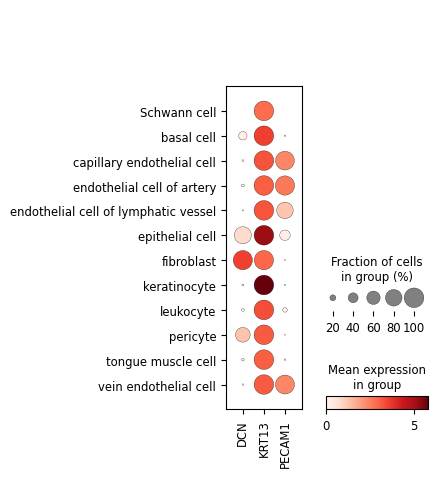

In [36]:
# Example: make an expression dot plot
adata.var_names = adata.var["feature_name"]
adata.X = adata.X * 10000
adata = adata[(adata.X.sum(1) > 0), :]  # remove cells that don't express any of the selected genes
sc.pp.log1p(adata)
sc.pl.dotplot(adata, adata.var["feature_name"], groupby='cell_type');

**🚨 NOTE:** The Census package provides a convinient way to get an AnnData object without creating an Experiment Query:

```python
adata = cellxgene_census.get_anndata(
  census = census,
  organism = organism,
  var_value_filter = gene_filter,
  obs_value_filter = cell_filter,
  column_names = cell_columns,
)
```


#### Getting the expression data and metadata

An`ExperimentAxisQuery` has all the necessary functionality to obtain the expression matrix along with the corresponding cell and gene metadata.

`to_anndata()` (shown in the previous section) uses many of these methods under the hood.

Let's take a closer look. First, we can get the cell and gene metadata as follows:

In [37]:
# Get cell metadata, only cell types and SOMA IDs
obs = query.obs(column_names = ["soma_joinid", "cell_type"]).concat().to_pandas()
obs

,soma_joinid,cell_type,tissue_general
0,6763612,epithelial cell,tongue
1,6763613,epithelial cell,tongue
2,6763614,epithelial cell,tongue
3,6763615,epithelial cell,tongue
4,6763616,epithelial cell,tongue
...,...,...,...
45055,53548544,keratinocyte,tongue
45056,53548545,keratinocyte,tongue
45057,53548546,basal cell,tongue
45058,53548547,keratinocyte,tongue


In [38]:
# Get gene metadata
var = query.var().concat().to_pandas()
var

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
0,299,ENSG00000011465,DCN,12941,7905731,75319655
1,12852,ENSG00000171401,KRT13,2913,712612,62927690
2,28763,ENSG00000261371,PECAM1,7741,7739030,64633082


Now let's take a look at expression matrix. There's a method `X()` that works similarly to reading a SOMA `SparseNDArray`, it retunrs a reader that can be then used to create matrix iterators.

Importantly `X()` will only return the rows and columns corresponding to cells and genes in the query, respectively.

In [39]:
# Get reader, results, and concatenate them.
# We need to specify the layer.
X = query.X(layer_name = "raw").tables().concat()
X

pyarrow.Table
soma_dim_0: int64
soma_dim_1: int64
soma_data: float
----
soma_dim_0: [[6763612,6763613,6763614,6763615,6763616,...,53548430,53548466,53548497,53548507,53548548]]
soma_dim_1: [[299,299,299,299,299,...,28763,28763,28763,28763,28763]]
soma_data: [[8,6,1,6,3,...,16,1,2,1,1]]

Same as before, we can transform this matrix to other formats:

In [40]:
# SciPy formats
scipy_coo = scipy.sparse.coo_matrix((X["soma_data"], (X["soma_dim_0"], X["soma_dim_1"])))
scipy_coo

<53548549x28764 sparse matrix of type '<class 'numpy.float32'>'
	with 63579 stored elements in COOrdinate format>

**🚨 NOTE:** The shape of this matrix is 52,668,282 rows by 27,554 columns.

However we know that there are 45K cells and 3 genes in our query. The reason for this discrepancy is that we are using the SOMA IDs as the row and column indices.

We can re-index these values to strip away all other cells and genes not included in our query result. Our team is about to release a method that makes this process a one-liner, for now we'll have to do the following:

In [41]:
# Reset the cell indeces to go from 0 to N (number of cells in the query)
obs_index = query.indexer.by_obs(X["soma_dim_0"])

# Reset the gene indeces to go from 0 to N (number of genes in the query)
var_index = query.indexer.by_var(X["soma_dim_1"])

# Get cell and gene soma IDs of the query
obs_ids = query.obs_joinids().to_numpy()[:numpy.max(obs_index) + 1]
var_ids = query.var_joinids().to_numpy()[:numpy.max(var_index) + 1]

# Make scipy.coo matrix
x_coo = scipy.sparse.coo_matrix((X["soma_data"].to_numpy(), (obs_index, var_index)))

In [42]:
x_coo

<45060x3 sparse matrix of type '<class 'numpy.float32'>'
	with 63579 stored elements in COOrdinate format>

In [43]:
# Get cell and gene soma IDs of the query
obs_ids = query.obs_joinids().to_numpy()[:numpy.max(obs_index) + 1]
var_ids = query.var_joinids().to_numpy()[:numpy.max(var_index) + 1]

# Set obs/var index as the SOMA IDs
obs = obs.set_index("soma_joinid")
var = var.set_index("soma_joinid")

In [44]:
obs.loc[obs_ids,]

,cell_type,tissue_general
soma_joinid,,
6763612,epithelial cell,tongue
6763613,epithelial cell,tongue
6763614,epithelial cell,tongue
6763615,epithelial cell,tongue
6763616,epithelial cell,tongue
...,...,...
53548544,keratinocyte,tongue
53548545,keratinocyte,tongue
53548546,basal cell,tongue


In [45]:
var.loc[var_ids,]

,feature_id,feature_name,feature_length,nnz,n_measured_obs
soma_joinid,,,,,
299,ENSG00000011465,DCN,12941,7905731,75319655
12852,ENSG00000171401,KRT13,2913,712612,62927690
28763,ENSG00000261371,PECAM1,7741,7739030,64633082


**🚨 NOTE:** Just like a file, a query should be closed.

In [46]:
query.close()

### Efficient compute capabilities of Census

Census has some methods that makes use of SOMA streaming capabilities (iterators) to make it possible to apply  common calculations on million of cells, using a common laptop.


#### Calculating average and variance across genes or cells

The Census method `mean_variance` enables calculation of average values across rows (cells) or genes (columns) of the X matrix in the context of an `ExperimentAxisQuery` which we learned how to use in the last section.

Let's see how this works. First we create an `ExperimentAxisQuery` [link text](https://)

In [47]:
# Set filters
cell_filter = (
  "is_primary_data == True "
  "and tissue_general == 'lung' "
  "and cell_type == 'epithelial cell' "
  "and disease == 'small cell lung carcinoma'"
 )

gene_filter = "feature_name in ['KRAS', 'AQP4']"

# Create query
query = census["census_data"]["homo_sapiens"].axis_query(
  measurement_name="RNA",
  obs_query=tiledbsoma.AxisQuery(value_filter=cell_filter),
  var_query=tiledbsoma.AxisQuery(value_filter=gene_filter)
)

In [48]:
query.n_obs, query.n_vars

(25988, 2)

Now we can use the Census `mean_variance()`. In this example we calculate mean and variance across cells.


In [49]:
from cellxgene_census.experimental.pp import mean_variance

mean_variance_df = mean_variance(
    query,
    axis=0,
    calculate_mean=True,
    calculate_variance=True,
    #nnz_only = True,
)
mean_variance_df

,mean,variance
soma_joinid,,
6706,18.114668,829.320056
12982,0.018932,0.099153


In [50]:
query.var().concat().to_pandas()

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
0,6706,ENSG00000133703,KRAS,9230,21891125,76922693
1,12982,ENSG00000171885,AQP4,5943,3274017,70337111


There are a few knobs we can tune in this method:

- `layer` the layer from X to use, defaults to `"raw"`.
- `axis` perform calculations across rows (`0`) or columns (`1`).
- `calculate_mean` whether to calculate mean.
- `calculate_variance` whether to calculate variance.
- `nnz_only` whether to do calculations only on non-zero values.


**🚨 NOTE:** Just like a file, a query should be closed.

In [51]:
query.close()

#### Getting highly variable genes

Similarly to calculating gene expression mean and variance, we can efficiently find the highest variable genes (memory-efficiently, across millions of cells) using `highly_variable_genes()`.

And this method also works with an `ExperimentAxisQuery`.

In [52]:
cell_filter = (
  "is_primary_data == True "
  "and tissue_general == 'lung' "
  "and cell_type == 'T cell' "
  "and disease == 'small cell lung carcinoma'"
 )

# Create query
query = census["census_data"]["homo_sapiens"].axis_query(
  measurement_name="RNA",
  obs_query=tiledbsoma.AxisQuery(value_filter=cell_filter),
)

In [53]:
query.n_obs

3898

In [54]:
from cellxgene_census.experimental.pp import highly_variable_genes

hvg_df = highly_variable_genes(
    query,
    n_top_genes = 200,
    #batch_key = ["dataset_id"]
)
hvg_df.query("highly_variable == True")

,means,variances,highly_variable_rank,variances_norm,highly_variable
soma_joinid,,,,,
179,0.015136,0.057508,162.0,2.909841,True
295,0.084146,0.350629,152.0,2.969717,True
391,5.670600,180.631524,192.0,2.758504,True
483,0.184197,0.956055,114.0,3.242163,True
525,0.071832,0.379237,82.0,3.834492,True
...,...,...,...,...,...
32040,1.384043,53.327710,8.0,8.311249,True
32045,0.133145,1.294303,67.0,4.149883,True
32258,0.041816,0.152472,198.0,2.699364,True


In [55]:
query.var().concat().to_pandas()

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
0,0,ENSG00000000003,TSPAN6,4530,4811135,77128603
1,1,ENSG00000000005,TNMD,1476,269136,64017621
2,2,ENSG00000000419,DPM1,9276,18420588,77502438
3,3,ENSG00000000457,SCYL3,6883,9268173,76952827
4,4,ENSG00000000460,C1orf112,5970,6484239,76979490
...,...,...,...,...,...,...
60532,60532,ENSG00000288718,ENSG00000288718.1,1070,4,1248980
60533,60533,ENSG00000288719,ENSG00000288719.1,4252,2826,1248980
60534,60534,ENSG00000288724,ENSG00000288724.1,625,36,1248980
60535,60535,ENSG00000290735,ENSG00000290735.1,4103,128,49359


**🚨 NOTE:** Just like a file, a query should be closed.

In [56]:
query.close()

# Training a PyTorch Model

This section shows how to train a Logistic Regression model in PyTorch using the Census API's `experimental.ml.ExperimentDataPipe` class. This is intended only to demonstrate the use of the `ExperimentDataPipe`, and not as an example of how to train a biologically useful model.

This tutorial assumes a basic familiarity with PyTorch and the Census API. See the [Querying and fetching the single-cell data and cell/gene metadata](https://chanzuckerberg.github.io/cellxgene-census/notebooks/api_demo/census_query_extract.html) notebook tutorial for a quick primer on Census API usage.

**Contents**

* [Open the Census](#Open-the-Census)
* [Create a DataLoader](#Create-a-DataLoader)
* [Define the model](#Define-the-model)
* [Train the model](#Train-the-model)
* [Make predictions with the model](#Make-predictions-with-the-model)


## Open the Census

First, obtain a handle to the Census data, in the usual manner:

In [1]:
import cellxgene_census

census = cellxgene_census.open_soma()

The "stable" release is currently 2024-07-01. Specify 'census_version="2024-07-01"' in future calls to open_soma() to ensure data consistency.


## Create an ExperimentDataPipe

To train a model in PyTorch using this `census` data object, first instantiate an `ExperimentDataPipe` as follows:

In [2]:
import cellxgene_census.experimental.ml as census_ml
import tiledbsoma as soma

experiment = census["census_data"]["homo_sapiens"]

experiment_datapipe = census_ml.ExperimentDataPipe(
    experiment,
    measurement_name="RNA",
    X_name="raw",
    obs_query=soma.AxisQuery(value_filter="tissue_general == 'tongue' and is_primary_data == True"),
    obs_column_names=["cell_type"],
    batch_size=128,
    shuffle=True,
    soma_chunk_size=10_000,
)

/opt/cellxgene-census/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### `ExperimentDataPipe` class explained

This class provides an implementation of PyTorch's [DataPipe interface](https://pytorch.org/data/main/torchdata.datapipes.iter.html), which defines a common mechanism for wrapping and accessing training data from any underlying source. The `ExperimentDataPipe` class encapsulates the details of querying and retrieving Census data from a single SOMA `Experiment` and returning it to the caller as PyTorch Tensors. Most importantly, it retrieves the data lazily from the Census in batches, avoiding having to load the entire training dataset into memory at once. (Note: PyTorch also provides `DataSet` as a legacy interface for wrapping and accessing training data sources, but a `DataPipe` can be used interchangeably.)


### `ExperimentDataPipe` parameters explained

The constructor only requires a single parameter, `experiment`, which is a `soma.Experiment` containing the data of the organism to be used for training.

To retrieve a subset of the Experiment's data, along either the `obs` or `var` axes, you may specify query filters via the `obs_query` and `var_query` parameters, which are both `soma.AxisQuery` objects.

The values for the prediction label(s) that you intend to use for training are specified via the `obs_column_names` array.

The `batch_size` allows you to specify the number of obs rows (cells) to be returned by each return PyTorch tensor. You may exclude this parameter if you want single rows (`batch_size=1`).

The `shuffle` flag allows you to randomize the ordering of the training data for each training epoch. Note:
* You should use this flag instead of the `DataLoader` `shuffle` flag, as `DataLoader` does not support shuffling when used with an `IterDataPipe` dataset.
* PyTorch's TorchData library provides a [Shuffler](https://pytorch.org/data/main/generated/torchdata.datapipes.iter.Shuffler.html) `DataPipe`, which is alternate mechanism one can use to perform shuffling of an `IterDataPipe`. However, the `Shuffler` will not "globally" randomize the training data, as it only "locally" randomizes the ordering of the training data within fixed-size "windows". Due to the layout of Census data, a given "window" of Census data may be highly homogeneous in terms of its `obs` axis attribute values, and so this shuffling strategy may not provide sufficient randomization for certain types of models.

The `soma_chunk_size` sets the number of rows of data that are retrieved from the Census and held in memory at a given time. This controls
 the maximum memory usage of the `ExperimentDataPipe`. Smaller values will require less memory but will also result in lower read performance. If you are running out of memory when training a model, try reducing this value. The default is set to retrieve ~1GB of data per chunk, which takes into account how many `var` (gene) columns are being requested. This parameter also affects the granularity of the "global" shuffling step when `shuffle=True` (see ``shuffle`` parameter API docs for details).

You can inspect the shape of the full dataset, without causing the full dataset to be loaded:

In [3]:
experiment_datapipe.shape

(15020, 60530)

## Split the dataset

You may split the overall dataset into the typical training, validation, and test sets by using the PyTorch [RandomSplitter](https://pytorch.org/data/main/generated/torchdata.datapipes.iter.RandomSplitter.html#torchdata.datapipes.iter.RandomSplitter) `DataPipe`. Using PyTorch's functional form for chaining `DataPipe`s, this is done as follows:

In [4]:
train_datapipe, test_datapipe = experiment_datapipe.random_split(weights={"train": 0.8, "test": 0.2}, seed=1)

## Create the DataLoader

With the full set of DataPipe operations chained together, we can now instantiate a PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) on the training data. 

In [5]:
experiment_dataloader = census_ml.experiment_dataloader(train_datapipe)

Alternately, you can instantiate a `DataLoader` object directly via its constructor. However, many of the parameters are not usable with iterable-style DataPipes, which is the case for `ExperimentDataPipe`. In particular, the `shuffle`, `batch_size`, `sampler`, `batch_sampler`, `collate_fn` parameters should not be specified. Using `experiment_dataloader` helps enforce correct usage.

## Define the model

With the training data retrieval code now in place, we can move on to defining a simple logistic regression model, using PyTorch's `torch.nn.Linear` class:

In [6]:
import torch


class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()  # noqa: UP008
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

Next, we define a function to train the model for a single epoch:

In [7]:
def train_epoch(model, train_dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = batch

        X_batch = X_batch.float().to(device)

        # Perform prediction
        outputs = model(X_batch)

        # Determine the predicted label
        probabilities = torch.nn.functional.softmax(outputs, 1)
        predictions = torch.argmax(probabilities, axis=1)

        # Compute the loss and perform back propagation

        y_batch = y_batch.flatten()
        y_batch = y_batch.to(device)

        train_correct += (predictions == y_batch).sum().item()
        train_total += len(predictions)

        loss = loss_fn(outputs, y_batch.long())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss /= train_total
    train_accuracy = train_correct / train_total
    return train_loss, train_accuracy

Note the line, `X_batch, y_batch = batch`. Since the `train_dataloader` was configured with `batch_size=16`, these variables will hold tensors of rank 2. The `X_batch` tensor will appear, for example, as:

```
tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 2.,  ..., 0., 3., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 8.]])
      
```

For `batch_size=1`, the tensors will be of rank 1. The `X_batch` tensor will appear, for example, as:

```
tensor([0., 0., 0.,  ..., 1., 0., 0.])
```
    
For `y_batch`, this will contain the user-specified `obs` `cell_type` training labels. By default, these are encoded using a LabelEncoder and it will be a matrix where each column represents the encoded values of each column specified in `obs_column_names` when creating the datapipe (in this case, only the cell type). It will look like this:

```
tensor([1, 1, 3, ..., 2, 1, 4])

```
Note that cell type values are integer-encoded values, which can be decoded using `experiment_datapipe.obs_encoders` (more on this below).


## Train the model

Finally, we are ready to train the model. Here we instantiate the model, a loss function, and an optimization method and then iterate through the desired number of training epochs. Note how the `train_dataloader` is passed into `train_epoch`, where for each epoch it will provide a new iterator through the training dataset.

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# The size of the input dimension is the number of genes
input_dim = experiment_datapipe.shape[1]

# The size of the output dimension is the number of distinct cell_type values
cell_type_encoder = experiment_datapipe.obs_encoders["cell_type"]
output_dim = len(cell_type_encoder.classes_)

model = LogisticRegression(input_dim, output_dim).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-05)

n_epochs = 10
for epoch in range(n_epochs):
    train_loss, train_accuracy = train_epoch(model, experiment_dataloader, loss_fn, optimizer, device)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.7f} Accuracy {train_accuracy:.4f}")

Epoch 1: Train Loss: 0.0164523 Accuracy 0.3699
Epoch 2: Train Loss: 0.0145778 Accuracy 0.4928
Epoch 3: Train Loss: 0.0142274 Accuracy 0.4965
Epoch 4: Train Loss: 0.0140366 Accuracy 0.5423
Epoch 5: Train Loss: 0.0139020 Accuracy 0.6057
Epoch 6: Train Loss: 0.0137726 Accuracy 0.7272
Epoch 7: Train Loss: 0.0136123 Accuracy 0.8630
Epoch 8: Train Loss: 0.0134781 Accuracy 0.9024
Epoch 9: Train Loss: 0.0133959 Accuracy 0.9071
Epoch 10: Train Loss: 0.0133454 Accuracy 0.9126


## Make predictions with the model

To make predictions with the model, we first create a new `DataLoader` using the `test_datapipe`, which provides the "test" split of the original dataset. For this example, we will only make predictions on a single batch of data from the test split.

In [9]:
experiment_dataloader = census_ml.experiment_dataloader(test_datapipe)
X_batch, y_batch = next(iter(experiment_dataloader))

Next, we invoke the model on the `X_batch` input data and extract the predictions:

In [10]:
model.eval()

model.to(device)
outputs = model(X_batch.to(device))

probabilities = torch.nn.functional.softmax(outputs, 1)
predictions = torch.argmax(probabilities, axis=1)

display(predictions)

tensor([ 8,  1,  1,  8,  7,  7,  1,  8,  1,  8,  5,  1,  7,  1,  1,  1,  1,  7,
         1,  7,  1,  1,  1,  1,  1,  7,  6,  8,  1,  1,  8,  8,  5,  5,  1,  1,
         8,  7,  1,  7,  1,  1,  1,  1,  7,  1,  8,  5,  8,  1,  1,  1,  8,  2,
         8,  1,  1,  7,  7,  1,  1,  1,  7,  1,  7,  7,  5,  7,  1,  5,  5,  7,
         8,  1,  1,  1, 11,  5,  1,  1,  1,  8,  1,  1,  7,  7,  1,  7,  8,  1,
         1,  5,  1,  1,  5,  1,  8,  5,  5,  1,  1,  7,  7,  7,  5,  1,  7,  7,
         1,  7,  5,  7,  1,  8,  1,  5,  7,  1,  1,  1,  1,  5,  8,  5,  1,  1,
         1,  7])

The predictions are returned as the encoded values of `cell_type` label. To recover the original cell type labels as strings, we decode using the encoders from `experiment_datapipe.obs_encoders`.

At inference time, if the model inputs are not obtained via an `ExperimentDataPipe`, one could pickle the encoder at training time and save it along with the model. Then, at inference time it can be unpickled and used as shown below.

In [11]:
cell_type_encoder = experiment_datapipe.obs_encoders["cell_type"]

predicted_cell_types = cell_type_encoder.inverse_transform(predictions.cpu())

display(predicted_cell_types)

array(['leukocyte', 'basal cell', 'basal cell', 'leukocyte',
       'keratinocyte', 'keratinocyte', 'basal cell', 'leukocyte',
       'basal cell', 'leukocyte', 'epithelial cell', 'basal cell',
       'keratinocyte', 'basal cell', 'basal cell', 'basal cell',
       'basal cell', 'keratinocyte', 'basal cell', 'keratinocyte',
       'basal cell', 'basal cell', 'basal cell', 'basal cell',
       'basal cell', 'keratinocyte', 'fibroblast', 'leukocyte',
       'basal cell', 'basal cell', 'leukocyte', 'leukocyte',
       'epithelial cell', 'epithelial cell', 'basal cell', 'basal cell',
       'leukocyte', 'keratinocyte', 'basal cell', 'keratinocyte',
       'basal cell', 'basal cell', 'basal cell', 'basal cell',
       'keratinocyte', 'basal cell', 'leukocyte', 'epithelial cell',
       'leukocyte', 'basal cell', 'basal cell', 'basal cell', 'leukocyte',
       'capillary endothelial cell', 'leukocyte', 'basal cell',
       'basal cell', 'keratinocyte', 'keratinocyte', 'basal cell',
       'b

Finally, we create a Pandas DataFrame to examine the predictions:

In [12]:
import pandas as pd

display(
    pd.DataFrame(
        {
            "actual cell type": cell_type_encoder.inverse_transform(y_batch.ravel().numpy()),
            "predicted cell type": predicted_cell_types,
        }
    )
)

,actual cell type,predicted cell type
0,leukocyte,leukocyte
1,leukocyte,basal cell
2,keratinocyte,basal cell
3,leukocyte,leukocyte
4,keratinocyte,keratinocyte
...,...,...
123,epithelial cell,epithelial cell
124,basal cell,basal cell
125,basal cell,basal cell
126,basal cell,basal cell


# Similarity Search (NEW!)

### Find the most similar Census cells in any other data with embeddings vector search

This section demonstrates the experimental API in the Python `cellxgene_census` package to search Census embeddings using [TileDB-Vector-Search](https://github.com/TileDB-Inc/TileDB-Vector-Search) indexes. We will generate [scVI embeddings](https://docs.scvi-tools.org/en/1.0.0/tutorials/notebooks/api_overview.html) for some test cells, search the Census scVI embeddings for nearest neighbors, and use them to predict cell type and tissue of the test cells.

To reproduce this notebook, `pip install 'cellxgene_census[experimental]' scvi-tools` and obtain the [pbmc3k blood cells data](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) and scVI model:

In [ ]:
!mkdir -p data
!wget --no-check-certificate -q -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
!tar -xzf data/pbmc3k_filtered_gene_bc_matrices.tar.gz -C data/

!mkdir -p scvi-human-2024-02-12
!wget --no-check-certificate -q -O scvi-human-2024-02-12/model.pt https://cellxgene-contrib-public.s3.us-west-2.amazonaws.com/models/scvi/2024-02-12/homo_sapiens/model.pt

Pin a few deps (cf. [mudata#77](https://github.com/scverse/mudata/issues/77)):

In [ ]:
!pip install anndata==0.10.8 flax==0.8.5

### Contents

1. Loading and embedding pbmc3k cells.

2. Search for similar Census cells.

3. Predicting cell metadata.

⚠️ Note that the Census RNA data includes duplicate cells present across multiple datasets. Duplicate cells can be filtered in or out using the cell metadata variable `is_primary_data` which is described in the [Census schema](https://github.com/chanzuckerberg/cellxgene-census/blob/main/docs/cellxgene_census_schema.md#repeated-data).

## Loading and embedding pbmc3k cells


In [ ]:
import warnings

warnings.filterwarnings("ignore")

import anndata
import cellxgene_census
import cellxgene_census.experimental
import pandas as pd
import scanpy as sc
import scvi

Load the pmbc3k cell data into an AnnData:

In [ ]:
adata = sc.read_10x_mtx("data/filtered_gene_bc_matrices/hg19/", var_names="gene_ids")
adata.var["ensembl_id"] = adata.var.index
adata.obs["n_counts"] = adata.X.sum(axis=1)
adata.obs["joinid"] = list(range(adata.n_obs))
adata.obs["batch"] = "unassigned"

Run them through the scVI forward pass and extract their latent representation (embedding):

In [ ]:
scvi.model.SCVI.prepare_query_anndata(adata, "scvi-human-2024-02-12")
vae_q = scvi.model.SCVI.load_query_data(
    adata,
    "scvi-human-2024-02-12",
)

# This allows for a simple forward pass
vae_q.is_trained = True
latent = vae_q.get_latent_representation()
adata.obsm["scvi"] = latent

The scVI embedding vectors for each cell are now stored in the `scvi` obsm layer. Lastly, clean up the AnnData a little:

In [ ]:
# filter out missing features
adata = adata[:, adata.var["gene_symbols"].notnull().values].copy()
adata.var.set_index("gene_symbols", inplace=True)
# assign placeholder cell_type and tissue_general labels
adata.var_names = adata.var["ensembl_id"]
adata.obs["cell_type"] = "Query - PBMC 10X"
adata.obs["tissue_general"] = "Query - PBMC 10X"

And for visualization, compute leiden clusters on the scVI embeddings. These will come at handy later on.

In [ ]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep="scvi")
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color="leiden")

## Search for similar Census cells

Use the CELLxGENE Census experimental API to search the vector index of scVI embeddings.

In [ ]:
%%time
CENSUS_VERSION = "2023-12-15"
neighbors = cellxgene_census.experimental.find_nearest_obs(
    "scvi", "homo_sapiens", CENSUS_VERSION, query=adata, k=30, memory_GiB=8, nprobe=20
)

This accessed the cell embeddings in the `scvi` obsm layer and searched the latent space for the k nearest neighbors (by Euclidean distance) among the Census cell embeddings, returning the distances and obs `soma_joinids` (k for each query cell).

In [ ]:
neighbors

To explore these results, fetch an AnnData with each query cell’s (single) nearest neighbor in scVI’s latent space, including their embedding vectors:

In [ ]:
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    neighbors_adata = cellxgene_census.get_anndata(
        census,
        "homo_sapiens",
        "RNA",
        obs_coords=sorted(neighbors.neighbor_ids[:, 0].tolist()),
        obs_embeddings=["scvi"],
        X_name="normalized",
        column_names={"obs": ["soma_joinid", "tissue", "tissue_general", "cell_type"]},
    )
neighbors_adata.var_names = neighbors_adata.var["feature_id"]

Make a UMAP visualization of these nearest neighbors:

In [ ]:
sc.pp.neighbors(neighbors_adata, n_neighbors=15, use_rep="scvi")
sc.tl.umap(neighbors_adata)
sc.pl.umap(neighbors_adata, color="tissue_general")

As expected, the nearest neighbors are largely Census blood cells, with some distinct cell type clusters.

Now display the pbmc3k query cells together with their Census nearest neighbors:

In [ ]:
adata_concat = anndata.concat([adata, neighbors_adata])
sc.pp.neighbors(adata_concat, n_neighbors=15, use_rep="scvi")
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=["tissue_general"])

The neighbor clusters appear to correspond to cell type heterogeneity also present in the query.

## Predicting cell metadata

The experimental API also has a method to predict metadata attributes of the query cells, like `tissue_general` and `cell_type`, based on the Census nearest neighbors.

In [ ]:
predictions = cellxgene_census.experimental.predict_obs_metadata(
    "homo_sapiens", CENSUS_VERSION, neighbors, ["tissue_general", "cell_type"]
)
predictions

Unlike the above visualizations of single nearest neighbors, these predictions are informed by each query cell’s k=30 neighbors, with an attached confidence score.

These predictions can be added to the original AnnData object for visualization.

In [ ]:
predictions.index = adata.obs.index
predictions = predictions.rename(columns={"cell_type": "predicted_cell_type"})
adata.obs = pd.concat([adata.obs, predictions], axis=1)

In [ ]:
sc.pl.umap(adata, color="predicted_cell_type")

Now the leiden clusters calculated at the beginning can be annotated by popular vote, whereby each cluster gets assigned the most common predicted cell type from the previous step.

In [ ]:
adata.obs["predicted_consolidated_cell_type"] = ""
for leiden_cluster in adata.obs["leiden"].drop_duplicates():
    most_popular_type = (
        adata.obs.loc[adata.obs["leiden"] == leiden_cluster,].value_counts("predicted_cell_type").index[0]
    )
    adata.obs.loc[adata.obs["leiden"] == leiden_cluster, "predicted_consolidated_cell_type"] = most_popular_type

In [ ]:
sc.pl.umap(adata, color="predicted_consolidated_cell_type")